In [36]:
import numpy as np 
import pandas as pd 
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [29]:
#import keras
from keras.layers import Dense
from keras.models import Sequential
#from keras.layers import LSTM


In [30]:
import pandas as pd

# Load the cleaned CSV
df = pd.read_csv(r"C:\Users\LENOVO\Downloads\aqi_data.csv")

# Preview the first rows
df.head()
# Save as Pickle


,state,city,station,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,...,Predominant_Parameter,datetime,year,month,day,weekday,hour,temperature,altitude,humidity
0,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",68,64,17,4,28,31,40,...,PM2.5,2020-01-03 10:00:00,2020,1,3,Friday,10,26,76,52
1,Andhra_Pradesh,Rajamahendravaram,"Anand Kala Kshetram, Rajamahendravaram - APPCB",67,70,23,2,13,49,77,...,OZONE,2020-01-03 10:00:00,2020,1,3,Friday,10,39,115,54
2,Andhra_Pradesh,Tirupati,"Tirumala, Tirupati - APPCB",32,64,26,5,6,19,16,...,PM2.5,2020-01-03 10:00:00,2020,1,3,Friday,10,34,153,88
3,Andhra_Pradesh,Visakhapatnam,"GVM Corporation, Visakhapatnam - APPCB",93,93,31,3,9,57,61,...,PM10,2020-01-03 10:00:00,2020,1,3,Friday,10,30,405,79
4,Andhra_Pradesh,Amaravati,"Secretariat, Amaravati - APPCB",60,55,20,5,18,29,53,...,PM2.5,2020-01-05 06:00:00,2020,1,5,Sunday,6,27,102,72


In [ ]:

# # mark all NA values with 0
# df['AQI'].fillna(0, inplace=True)
# df.head
print(df.columns)


Index(['state', 'city', 'station', 'PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO',
       'OZONE', 'AQI', 'Predominant_Parameter', 'datetime', 'year', 'month',
       'day', 'weekday', 'hour', 'temperature', 'altitude', 'humidity'],
      dtype='object')


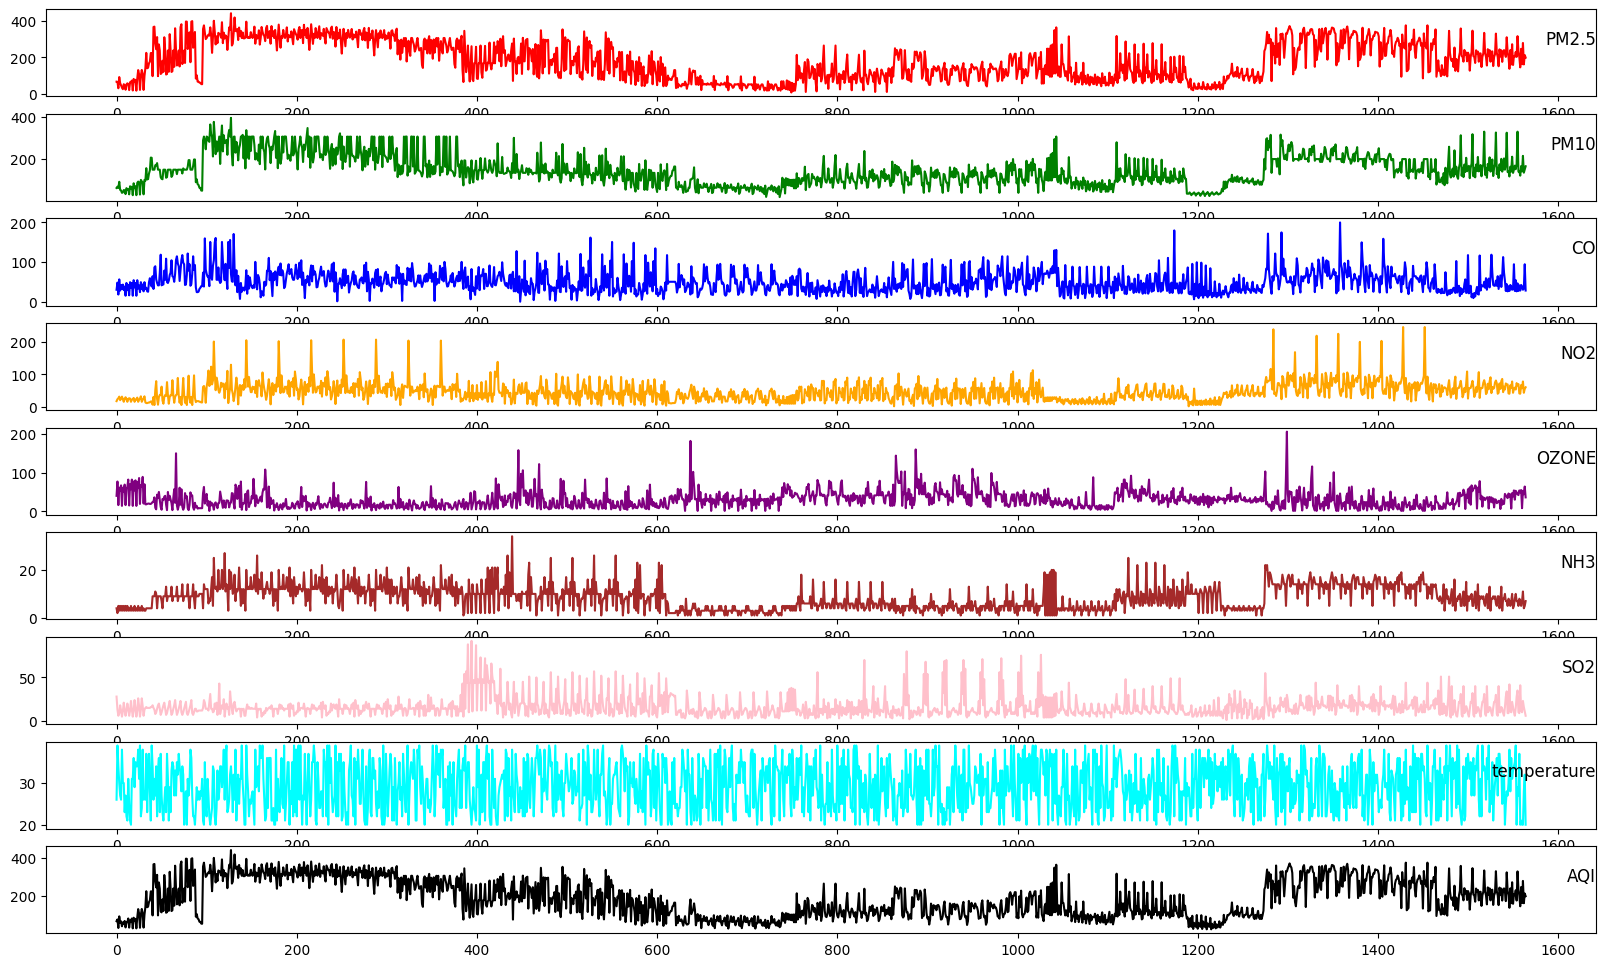

In [ ]:
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'cyan', 'black']

groups = ['PM2.5', 'PM10', 'CO', 'NO2', 'OZONE', 'NH3', 'SO2', 'temperature', 'AQI']

i = 1
plt.figure()
for group, color in zip(groups, colors):
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.subplot(len(groups), 1, i)
    plt.plot(df[group], color=color)   # 👈 set color here
    plt.title(group, y=0.5, loc='right')
    i += 1
plt.show()


DatetimeIndex(['2020-01-03 10:00:00', '2020-01-03 10:00:00',
               '2020-01-03 10:00:00', '2020-01-03 10:00:00',
               '2020-01-05 06:00:00', '2020-01-05 06:00:00',
               '2020-01-05 06:00:00', '2020-01-05 06:00:00',
               '2020-01-06 03:00:00', '2020-01-06 03:00:00',
               ...
               '2020-01-07 03:00:00', '2020-01-07 03:00:00',
               '2020-01-07 03:00:00', '2020-01-07 03:00:00',
               '2020-01-07 03:00:00', '2020-01-07 03:00:00',
               '2020-01-07 03:00:00', '2020-01-07 03:00:00',
               '2020-01-07 03:00:00', '2020-01-07 03:00:00'],
              dtype='datetime64[ns]', name='datetime', length=1565, freq=None)
datetime


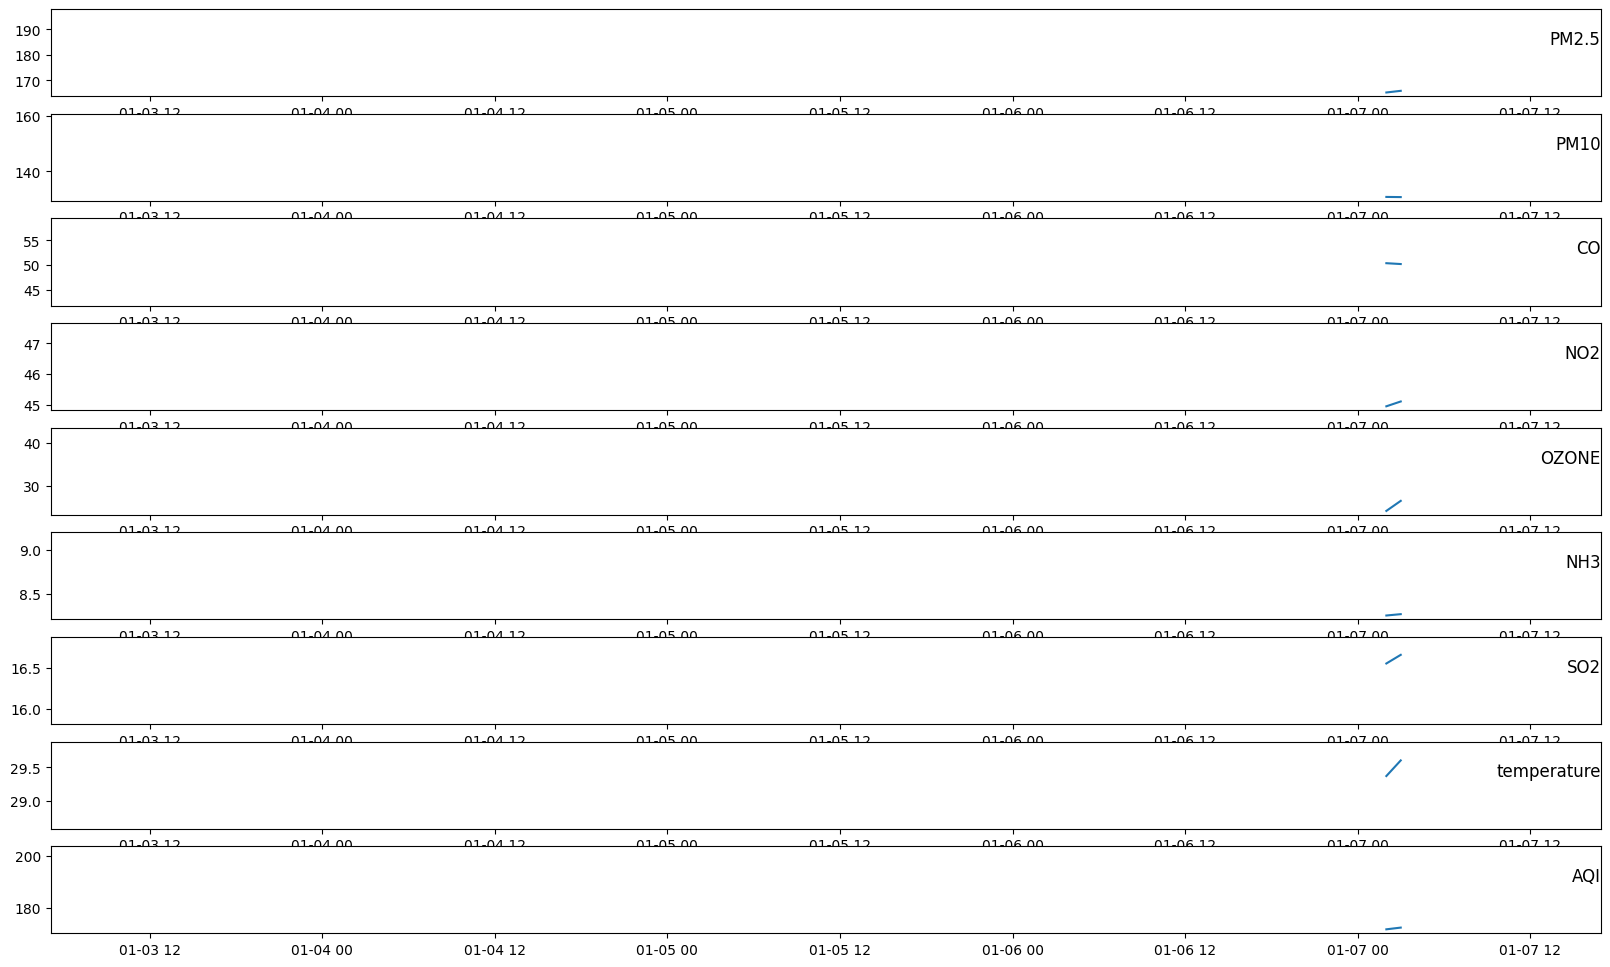

In [37]:
# Convert datetime column and set as index
df.columns = df.columns.str.strip()  # remove extra spaces
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

groups = ['PM2.5', 'PM10', 'CO', 'NO2', 'OZONE', 'NH3', 'SO2', 'temperature', 'AQI']
print(df.index)       # see what the index is
print(df.index.name)  # see if the index itself is 'datetime'


i = 1
plt.figure()
for group in groups:
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.subplot(len(groups), 1, i)
    plt.plot(df[group].resample("h").mean())   # <-- lowercase 'h'
    plt.title(group, y=0.5, loc='right')
    i += 1
plt.show()


### Time windowing dataset
**Series to supervised learning**

In [39]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
     if i == 0:
         names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
     else:
         names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
     agg.dropna(inplace=True)
 return agg

In [40]:
n_steps_in=1
n_steps_out=1

In [ ]:

df_numeric = df.select_dtypes(include='number')

# resample over hour and compute mean
df_resample = df_numeric.resample('h').mean()

# drop rows with more than 3 NaNs
mask = df_resample.isna().sum(axis=1) > 3
df_resample = df_resample.drop(index=df_resample[mask].index)

df_resample.head()



,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,year,month,day,hour,temperature,altitude,humidity
datetime,,,,,,,,,,,,,,,
2020-01-03 10:00:00,190.481865,159.181347,47.497409,9.150259,16.020725,58.632124,31.331606,195.373057,2020.0,1.0,3.0,10.0,29.264249,239.932642,61.202073
2020-01-05 06:00:00,196.312500,156.135417,46.520833,8.708333,15.859375,42.593750,42.645833,202.322917,2020.0,1.0,5.0,6.0,29.239583,247.281250,58.411458
2020-01-06 03:00:00,185.979592,151.168367,46.872449,8.525510,16.270408,52.056122,28.954082,192.433673,2020.0,1.0,6.0,3.0,28.642857,257.163265,59.316327
2020-01-06 06:00:00,188.505102,152.209184,47.530612,8.602041,16.535714,49.857143,33.938776,195.096939,2020.0,1.0,6.0,6.0,29.086735,248.040816,59.704082
2020-01-06 11:00:00,182.543147,146.629442,47.335025,8.517766,16.639594,53.451777,27.741117,189.426396,2020.0,1.0,6.0,11.0,29.827411,220.741117,60.573604


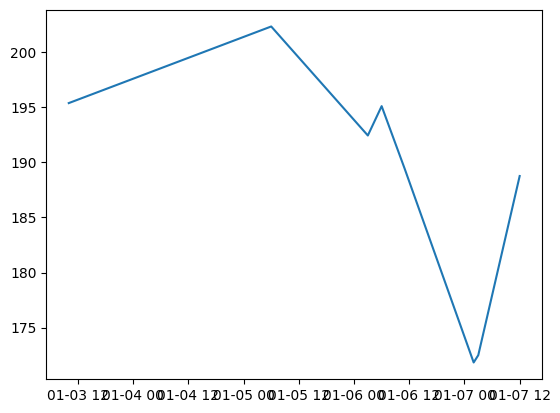

In [45]:

plt.plot(df_resample[group])


In [46]:
values = df_resample.values 

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps_in, n_steps_out)

# drop columns we don't want to predict
reframed.drop(reframed.columns[16:26].append(reframed.columns[27:]), axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.812301   1.000000   0.987162   1.000000   0.164948   1.000000   
2   1.000000   0.892613   0.609587   0.507028   0.000000   0.000000   
3   0.667365   0.717495   0.745533   0.303087   0.420198   0.589983   
4   0.748665   0.754190   1.000000   0.388458   0.691422   0.452876   
5   0.556739   0.557472   0.924379   0.294450   0.797615   0.677003   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.384660   0.771988        0.0         0.0        0.00         0.8   
2   1.000000   1.000000        0.0         0.0        0.50         0.4   
3   0.255355   0.675553        0.0         0.0        0.75         0.1   
4   0.526455   0.762929        0.0         0.0        0.75         0.4   
5   0.189386   0.576890        0.0         0.0        0.75         0.9   

   var13(t-1)  var14(t-1)  var15(t-1)   var1(t)  var12(t)  
1    0.524578    0.409303    1.000000  1.000000       0.4  
2    0.5

In [50]:
# Example: split into train/test
n_train_hours = int(len(values) * 0.7)   # 70% train, 30% test
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_Y = train[:, :-1], train[:, -1]
test_X, test_Y = test[:, :-1], test[:, -1]

# reshape into [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)


(4, 1, 16) (4,) (3, 1, 16) (3,)


Epoch 1/50
1/1 - 9s - loss: 0.3924 - val_loss: 0.3507 - 9s/epoch - 9s/step
Epoch 2/50
1/1 - 0s - loss: 0.3689 - val_loss: 0.3500 - 255ms/epoch - 255ms/step
Epoch 3/50
1/1 - 0s - loss: 0.3453 - val_loss: 0.3575 - 231ms/epoch - 231ms/step
Epoch 4/50
1/1 - 0s - loss: 0.3216 - val_loss: 0.3650 - 186ms/epoch - 186ms/step
Epoch 5/50
1/1 - 0s - loss: 0.3036 - val_loss: 0.3723 - 375ms/epoch - 375ms/step
Epoch 6/50
1/1 - 0s - loss: 0.2911 - val_loss: 0.3796 - 282ms/epoch - 282ms/step
Epoch 7/50
1/1 - 0s - loss: 0.2787 - val_loss: 0.3868 - 437ms/epoch - 437ms/step
Epoch 8/50
1/1 - 0s - loss: 0.2664 - val_loss: 0.3940 - 267ms/epoch - 267ms/step
Epoch 9/50
1/1 - 0s - loss: 0.2541 - val_loss: 0.4012 - 220ms/epoch - 220ms/step
Epoch 10/50
1/1 - 0s - loss: 0.2417 - val_loss: 0.4084 - 379ms/epoch - 379ms/step
Epoch 11/50
1/1 - 0s - loss: 0.2293 - val_loss: 0.4157 - 382ms/epoch - 382ms/step
Epoch 12/50
1/1 - 0s - loss: 0.2212 - val_loss: 0.4222 - 288ms/epoch - 288ms/step
Epoch 13/50
1/1 - 0s - loss: 0.

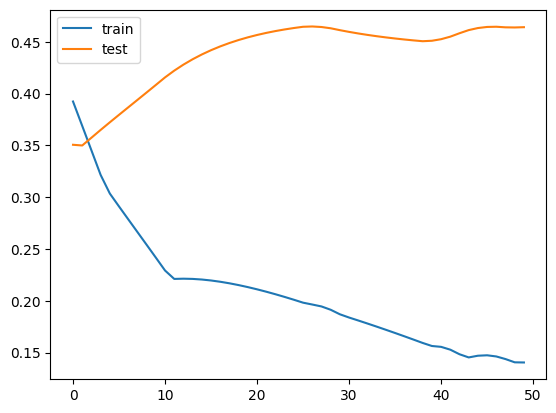

In [51]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as pyplot

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(
    train_X, train_Y,
    epochs=50,
    batch_size=72,
    validation_data=(test_X, test_Y),
    verbose=2,
    shuffle=False
)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [56]:
import numpy as np
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

# ✅ Ensure test_X is 3D before prediction
if len(test_X.shape) == 2:  
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# make a prediction
yhat = model.predict(test_X)

# reshape test_X back to 2D for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# --- FIX START ---
# scaler was trained on [target + features]
# so we need to keep same number of columns

# For forecast
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = inv_yhat[:, :scaler.n_features_in_]   # ✅ trim to scaler’s feature size
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# For actual
test_Y = test_Y.reshape((len(test_Y), 1))
inv_y = np.concatenate((test_Y, test_X_reshaped[:, 1:]), axis=1)
inv_y = inv_y[:, :scaler.n_features_in_]         # ✅ trim to scaler’s feature size
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# --- FIX END ---

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


1/1 [==============================] - 0s 304ms/step
Test RMSE: 14.723


In [57]:
import pickle  # ✅ Import pickle

# Serialize LSTM model into a file
with open('lstmModel.pkl', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model saved successfully as lstmModel.pkl")


Model saved successfully as lstmModel.pkl


In [60]:
import pickle

# De-serialize LSTM model using pickle
with open('lstmModel.pkl', 'rb') as handle:
    lstmModel = pickle.load(handle)

print("Model loaded successfully (pickle method)")


Model loaded successfully (pickle method)
